In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_swin_small'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = "swin_small_patch4_window7_224"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 40
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-4
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-8
    weight_decay = 1e-5
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),

        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames, 
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames,
        ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月21日 13:15:29


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            self.n_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            self.n_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            self.n_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.final_fc = nn.Sequential(
            nn.Linear(self.n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, self.target_size),
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.final_fc(feature)
        return output

# scheduler

In [17]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [18]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [19]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [20]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.grid(alpha=0.1)
    ax2.grid(alpha=0.1)
    for i, df_score in enumerate(list_df_score):
        ax1.plot(df_score['train_score'], label=f'fold {i}')
        ax2.plot(df_score['val_score'], label=f'fold {i}')
    ax1.set_title('Train Score')
    ax2.set_title('Val Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Train Score')
    ax2.set_ylabel('Val Score')
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 20m 41s) Loss: 6.0146(6.0146) Grad: nan  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 4.7669(5.3065) Grad: 33588.0430  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.5722(5.2882) Grad: 45047.0664  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 58s) Loss: 4.8279(4.8279) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.2882  avg_val_loss: 5.3822  time: 131s
Epoch 1 - avg_train_Score: 5.2882 avgScore: 5.3822
Epoch 1 - Save Best Score: 5.3822 Model
Epoch 1 - Save Best Loss: 5.3822 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.9033(5.3822) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 5.2647(5.2647) Grad: 152223.5938  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.0304(4.9798) Grad: 153300.3594  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.4363(4.9623) Grad: 123405.2344  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 4.4131(4.4131) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9623  avg_val_loss: 4.9514  time: 131s
Epoch 2 - avg_train_Score: 4.9623 avgScore: 4.9514
Epoch 2 - Save Best Score: 4.9514 Model
Epoch 2 - Save Best Loss: 4.9514 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.4891(4.9514) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 5.6213(5.6213) Grad: 666546.5000  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.8800(3.3921) Grad: 83049.1875  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.8597(3.2900) Grad: 5028.0552  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 2.0692(2.0692) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.2900  avg_val_loss: 2.4617  time: 130s
Epoch 3 - avg_train_Score: 3.2900 avgScore: 2.4617
Epoch 3 - Save Best Score: 2.4617 Model
Epoch 3 - Save Best Loss: 2.4617 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 2.2964(2.4617) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 1.8505(1.8505) Grad: nan  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5231(1.5523) Grad: 40603.9961  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4592(1.5392) Grad: 39290.2812  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 1.0554(1.0554) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.5392  avg_val_loss: 1.1814  time: 130s
Epoch 4 - avg_train_Score: 1.5392 avgScore: 1.1814
Epoch 4 - Save Best Score: 1.1814 Model
Epoch 4 - Save Best Loss: 1.1814 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.1520(1.1814) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 32s) Loss: 1.3245(1.3245) Grad: 328374.5312  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2659(1.2749) Grad: 74246.5938  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0880(1.2758) Grad: 72091.8516  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.9378(0.9378) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2758  avg_val_loss: 1.0050  time: 130s
Epoch 5 - avg_train_Score: 1.2758 avgScore: 1.0050
Epoch 5 - Save Best Score: 1.0050 Model
Epoch 5 - Save Best Loss: 1.0050 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.0047(1.0050) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 1.4733(1.4733) Grad: 383316.2188  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0985(1.1977) Grad: 34852.7344  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.7135(1.1988) Grad: 48707.8594  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9019(0.9019) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1988  avg_val_loss: 0.9643  time: 130s


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9576(0.9643) 


Epoch 6 - avg_train_Score: 1.1988 avgScore: 0.9643
Epoch 6 - Save Best Score: 0.9643 Model
Epoch 6 - Save Best Loss: 0.9643 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 1.0055(1.0055) Grad: 314871.2812  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0123(1.1150) Grad: 56178.8164  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1582(1.1155) Grad: 52405.4336  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9043(0.9043) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1155  avg_val_loss: 0.9260  time: 131s
Epoch 7 - avg_train_Score: 1.1155 avgScore: 0.9260
Epoch 7 - Save Best Score: 0.9260 Model
Epoch 7 - Save Best Loss: 0.9260 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8969(0.9260) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 1.1850(1.1850) Grad: 323707.2812  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9967(1.0340) Grad: 42510.0039  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3442(1.0383) Grad: 41552.4258  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8769(0.8769) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0383  avg_val_loss: 0.9016  time: 130s
Epoch 8 - avg_train_Score: 1.0383 avgScore: 0.9016
Epoch 8 - Save Best Score: 0.9016 Model
Epoch 8 - Save Best Loss: 0.9016 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8719(0.9016) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 37s) Loss: 0.9189(0.9189) Grad: 318389.6250  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8953(0.9864) Grad: 71277.2031  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7718(0.9856) Grad: 68156.0469  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8502(0.8502) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.9856  avg_val_loss: 0.8807  time: 131s
Epoch 9 - avg_train_Score: 0.9856 avgScore: 0.8807
Epoch 9 - Save Best Score: 0.8807 Model
Epoch 9 - Save Best Loss: 0.8807 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8919(0.8807) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 18s) Loss: 0.8853(0.8853) Grad: 309177.0000  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1260(0.9533) Grad: 81721.5156  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8641(0.9540) Grad: 54281.9648  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.8371(0.8371) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9540  avg_val_loss: 0.8743  time: 130s
Epoch 10 - avg_train_Score: 0.9540 avgScore: 0.8743
Epoch 10 - Save Best Score: 0.8743 Model
Epoch 10 - Save Best Loss: 0.8743 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8913(0.8743) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.7878(0.7878) Grad: 265414.7500  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8816(0.9133) Grad: 59190.8672  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8010(0.9129) Grad: 71709.2500  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8038(0.8038) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9129  avg_val_loss: 0.8622  time: 130s
Epoch 11 - avg_train_Score: 0.9129 avgScore: 0.8622
Epoch 11 - Save Best Score: 0.8622 Model
Epoch 11 - Save Best Loss: 0.8622 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8839(0.8622) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 45s) Loss: 0.9706(0.9706) Grad: 200140.6250  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0588(0.8747) Grad: 48871.4727  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9363(0.8726) Grad: 74477.0781  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8107(0.8107) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.8726  avg_val_loss: 0.8566  time: 131s
Epoch 12 - avg_train_Score: 0.8726 avgScore: 0.8566
Epoch 12 - Save Best Score: 0.8566 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8567(0.8566) 


Epoch 12 - Save Best Loss: 0.8566 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 48s) Loss: 0.8863(0.8863) Grad: 287029.5625  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7222(0.8970) Grad: 25640.9082  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9273(0.9015) Grad: 32970.0234  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.8175(0.8175) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9015  avg_val_loss: 0.8588  time: 131s
Epoch 13 - avg_train_Score: 0.9015 avgScore: 0.8588


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8786(0.8588) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.7833(0.7833) Grad: 245687.9844  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7792(0.8963) Grad: 50016.7734  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6891(0.8954) Grad: 66212.1172  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7732(0.7732) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8954  avg_val_loss: 0.8502  time: 131s
Epoch 14 - avg_train_Score: 0.8954 avgScore: 0.8502
Epoch 14 - Save Best Score: 0.8502 Model
Epoch 14 - Save Best Loss: 0.8502 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8628(0.8502) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 56s) Loss: 1.0461(1.0461) Grad: 212191.9375  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7917(0.8580) Grad: 78124.1406  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1252(0.8634) Grad: 46433.7852  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7915(0.7915) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8634  avg_val_loss: 0.8400  time: 130s
Epoch 15 - avg_train_Score: 0.8634 avgScore: 0.8400
Epoch 15 - Save Best Score: 0.8400 Model
Epoch 15 - Save Best Loss: 0.8400 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8203(0.8400) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 39s) Loss: 0.9237(0.9237) Grad: 291732.3438  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2587(0.8692) Grad: 40857.6094  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7371(0.8688) Grad: 30989.8164  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7849(0.7849) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8688  avg_val_loss: 0.8464  time: 130s
Epoch 16 - avg_train_Score: 0.8688 avgScore: 0.8464


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8086(0.8464) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 43s) Loss: 0.8087(0.8087) Grad: 215829.9062  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0458(0.8330) Grad: 33094.9414  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7727(0.8318) Grad: 39989.1484  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7942(0.7942) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8318  avg_val_loss: 0.8363  time: 130s
Epoch 17 - avg_train_Score: 0.8318 avgScore: 0.8363
Epoch 17 - Save Best Score: 0.8363 Model
Epoch 17 - Save Best Loss: 0.8363 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8014(0.8363) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.8579(0.8579) Grad: 240391.7500  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6468(0.8100) Grad: 56310.5352  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7082(0.8106) Grad: 64869.3203  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7691(0.7691) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8106  avg_val_loss: 0.8288  time: 130s
Epoch 18 - avg_train_Score: 0.8106 avgScore: 0.8288
Epoch 18 - Save Best Score: 0.8288 Model
Epoch 18 - Save Best Loss: 0.8288 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7983(0.8288) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 32s) Loss: 0.8821(0.8821) Grad: 254648.7500  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8211(0.8000) Grad: 40756.2109  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8704(0.8028) Grad: 37697.5430  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7440(0.7440) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8028  avg_val_loss: 0.8287  time: 130s
Epoch 19 - avg_train_Score: 0.8028 avgScore: 0.8287
Epoch 19 - Save Best Score: 0.8287 Model
Epoch 19 - Save Best Loss: 0.8287 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7894(0.8287) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 10s) Loss: 1.1328(1.1328) Grad: 254801.3438  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6796(0.8059) Grad: 90188.2422  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7784(0.8064) Grad: 60623.9141  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7771(0.7771) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8111(0.8268) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8064  avg_val_loss: 0.8268  time: 130s
Epoch 20 - avg_train_Score: 0.8064 avgScore: 0.8268
Epoch 20 - Save Best Score: 0.8268 Model
Epoch 20 - Save Best Loss: 0.8268 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 37s) Loss: 0.6069(0.6069) Grad: 176865.4375  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8749(0.7662) Grad: 76262.0312  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6576(0.7649) Grad: 43830.9336  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7695(0.7695) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.7649  avg_val_loss: 0.8249  time: 130s
Epoch 21 - avg_train_Score: 0.7649 avgScore: 0.8249
Epoch 21 - Save Best Score: 0.8249 Model
Epoch 21 - Save Best Loss: 0.8249 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8162(0.8249) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 38s) Loss: 0.6740(0.6740) Grad: 263128.5000  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9053(0.7562) Grad: 63648.9492  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6933(0.7592) Grad: 50911.2734  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7462(0.7462) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7592  avg_val_loss: 0.8228  time: 130s
Epoch 22 - avg_train_Score: 0.7592 avgScore: 0.8228
Epoch 22 - Save Best Score: 0.8228 Model
Epoch 22 - Save Best Loss: 0.8228 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8180(0.8228) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 1.1649(1.1649) Grad: 198701.4844  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6935(0.7662) Grad: 64180.7852  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6904(0.7664) Grad: 58737.3945  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7437(0.7437) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7664  avg_val_loss: 0.8193  time: 130s
Epoch 23 - avg_train_Score: 0.7664 avgScore: 0.8193
Epoch 23 - Save Best Score: 0.8193 Model
Epoch 23 - Save Best Loss: 0.8193 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8041(0.8193) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 0.6165(0.6165) Grad: 238186.1719  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7961(0.7442) Grad: 38996.1445  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5957(0.7473) Grad: 50072.1758  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7214(0.7214) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7473  avg_val_loss: 0.8168  time: 130s
Epoch 24 - avg_train_Score: 0.7473 avgScore: 0.8168
Epoch 24 - Save Best Score: 0.8168 Model
Epoch 24 - Save Best Loss: 0.8168 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7985(0.8168) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.7498(0.7498) Grad: 216776.4531  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0828(0.7312) Grad: 49593.2852  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7251(0.7323) Grad: 63645.8672  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7290(0.7290) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7323  avg_val_loss: 0.8159  time: 130s
Epoch 25 - avg_train_Score: 0.7323 avgScore: 0.8159
Epoch 25 - Save Best Score: 0.8159 Model
Epoch 25 - Save Best Loss: 0.8159 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8162(0.8159) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 2s) Loss: 0.9206(0.9206) Grad: 222290.8438  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6272(0.7284) Grad: 55997.0234  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8693(0.7264) Grad: 48688.0195  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7180(0.7180) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7264  avg_val_loss: 0.8179  time: 130s
Epoch 26 - avg_train_Score: 0.7264 avgScore: 0.8179


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8052(0.8179) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.7987(0.7987) Grad: 299577.8750  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9659(0.7185) Grad: 101006.1250  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6974(0.7198) Grad: 159335.2344  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7153(0.7153) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8018(0.8179) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7198  avg_val_loss: 0.8179  time: 130s
Epoch 27 - avg_train_Score: 0.7198 avgScore: 0.8179
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [28][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.7056(0.7056) Grad: 186765.0312  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7290(0.7079) Grad: 122854.5703  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8338(0.7039) Grad: 94722.5000  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7152(0.7152) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7039  avg_val_loss: 0.8157  time: 130s
Epoch 28 - avg_train_Score: 0.7039 avgScore: 0.8157
Epoch 28 - Save Best Score: 0.8157 Model
Epoch 28 - Save Best Loss: 0.8157 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7912(0.8157) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.9627(0.9627) Grad: 211470.2500  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7902(0.7004) Grad: 48603.1172  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2600(0.7055) Grad: 59024.7852  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7374(0.7374) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8112(0.8170) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7055  avg_val_loss: 0.8170  time: 130s
Epoch 29 - avg_train_Score: 0.7055 avgScore: 0.8170
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 40s) Loss: 0.7053(0.7053) Grad: 236189.5156  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7033(0.7001) Grad: 87178.8047  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5093(0.6997) Grad: 94470.2969  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7090(0.7090) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.6997  avg_val_loss: 0.8137  time: 131s
Epoch 30 - avg_train_Score: 0.6997 avgScore: 0.8137
Epoch 30 - Save Best Score: 0.8137 Model
Epoch 30 - Save Best Loss: 0.8137 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8071(0.8137) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 0.5930(0.5930) Grad: 255426.2969  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6065(0.7005) Grad: 131534.0781  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9229(0.6992) Grad: 84580.3047  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7038(0.7038) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.6992  avg_val_loss: 0.8110  time: 130s
Epoch 31 - avg_train_Score: 0.6992 avgScore: 0.8110
Epoch 31 - Save Best Score: 0.8110 Model
Epoch 31 - Save Best Loss: 0.8110 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8050(0.8110) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.5112(0.5112) Grad: 194013.5781  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6048(0.6946) Grad: 43699.1484  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6601(0.6935) Grad: 53786.1016  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7224(0.7224) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6935  avg_val_loss: 0.8095  time: 131s
Epoch 32 - avg_train_Score: 0.6935 avgScore: 0.8095
Epoch 32 - Save Best Score: 0.8095 Model
Epoch 32 - Save Best Loss: 0.8095 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7919(0.8095) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 13m 12s) Loss: 0.7682(0.7682) Grad: 205209.2969  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5231(0.6801) Grad: 86671.7891  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8557(0.6804) Grad: 93434.5000  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7306(0.7306) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.6804  avg_val_loss: 0.8105  time: 130s
Epoch 33 - avg_train_Score: 0.6804 avgScore: 0.8105


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7952(0.8105) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.5619(0.5619) Grad: 178030.3906  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5291(0.6773) Grad: 133395.9688  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6723(0.6771) Grad: 107851.3750  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7254(0.7254) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6771  avg_val_loss: 0.8084  time: 130s
Epoch 34 - avg_train_Score: 0.6771 avgScore: 0.8084
Epoch 34 - Save Best Score: 0.8084 Model
Epoch 34 - Save Best Loss: 0.8084 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7850(0.8084) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 56s) Loss: 0.7343(0.7343) Grad: 174318.2344  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8697(0.6772) Grad: 105854.7031  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5290(0.6771) Grad: 121771.9453  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7220(0.7220) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7878(0.8093) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6771  avg_val_loss: 0.8093  time: 130s
Epoch 35 - avg_train_Score: 0.6771 avgScore: 0.8093
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.6218(0.6218) Grad: 208452.9062  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7470(0.6731) Grad: 55499.4883  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2106(0.6769) Grad: 43298.0625  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7196(0.7196) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6769  avg_val_loss: 0.8090  time: 130s
Epoch 36 - avg_train_Score: 0.6769 avgScore: 0.8090


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7797(0.8090) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 54s) Loss: 0.9418(0.9418) Grad: 164877.9062  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7792(0.6797) Grad: 102873.2500  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5788(0.6769) Grad: 92108.2812  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7257(0.7257) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7865(0.8092) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6769  avg_val_loss: 0.8092  time: 130s
Epoch 37 - avg_train_Score: 0.6769 avgScore: 0.8092
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.7280(0.7280) Grad: 242457.8125  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6585(0.6680) Grad: 83904.0547  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5332(0.6665) Grad: 93120.7344  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7130(0.7130) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6665  avg_val_loss: 0.8071  time: 130s
Epoch 38 - avg_train_Score: 0.6665 avgScore: 0.8071


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7888(0.8071) 


Epoch 38 - Save Best Score: 0.8071 Model
Epoch 38 - Save Best Loss: 0.8071 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 52s) Loss: 0.5869(0.5869) Grad: 195575.5000  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5289(0.6667) Grad: 113739.7578  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6412(0.6686) Grad: 96991.1328  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7136(0.7136) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6686  avg_val_loss: 0.8080  time: 130s
Epoch 39 - avg_train_Score: 0.6686 avgScore: 0.8080


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7872(0.8080) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 56s) Loss: 0.6399(0.6399) Grad: 259212.7031  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5934(0.6608) Grad: 40377.2539  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5052(0.6625) Grad: 46536.8008  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7187(0.7187) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6625  avg_val_loss: 0.8076  time: 130s
Epoch 40 - avg_train_Score: 0.6625 avgScore: 0.8076


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7839(0.8076) 


/tmp/ipykernel_167072/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 0 result ==========
score: 0.8076
=========

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 4.9809(4.9809) Grad: 268638.4375  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.4710(5.3754) Grad: 48768.8594  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.9757(5.3557) Grad: 60325.4219  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 5.4394(5.4394) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.3557  avg_val_loss: 5.1308  time: 131s
Epoch 1 - avg_train_Score: 5.3557 avgScore: 5.1308
Epoch 1 - Save Best Score: 5.1308 Model
Epoch 1 - Save Best Loss: 5.1308 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 3.5133(5.1308) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 5.9145(5.9145) Grad: 201811.2344  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.6922(4.9712) Grad: 118437.6719  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.6176(4.9574) Grad: 44366.0430  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 4.9994(4.9994) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9574  avg_val_loss: 4.6545  time: 130s
Epoch 2 - avg_train_Score: 4.9574 avgScore: 4.6545
Epoch 2 - Save Best Score: 4.6545 Model
Epoch 2 - Save Best Loss: 4.6545 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 3.2056(4.6545) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 18s) Loss: 4.8514(4.8514) Grad: 224870.8594  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 2.0874(2.9289) Grad: 15905.2324  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.5142(2.8315) Grad: 17726.7109  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 2.0147(2.0147) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 2.8315  avg_val_loss: 1.7268  time: 131s
Epoch 3 - avg_train_Score: 2.8315 avgScore: 1.7268
Epoch 3 - Save Best Score: 1.7268 Model
Epoch 3 - Save Best Loss: 1.7268 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.4462(1.7268) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 1.3915(1.3915) Grad: 396573.7188  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4465(1.4434) Grad: 18779.4941  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4321(1.4351) Grad: 20772.3906  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 1.1388(1.1388) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.4351  avg_val_loss: 1.0667  time: 130s
Epoch 4 - avg_train_Score: 1.4351 avgScore: 1.0667
Epoch 4 - Save Best Score: 1.0667 Model
Epoch 4 - Save Best Loss: 1.0667 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.1240(1.0667) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 25s) Loss: 1.9135(1.9135) Grad: 275008.8750  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0399(1.2590) Grad: 17489.8047  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2090(1.2570) Grad: 19741.0059  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 1.0843(1.0843) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2570  avg_val_loss: 0.9930  time: 130s
Epoch 5 - avg_train_Score: 1.2570 avgScore: 0.9930
Epoch 5 - Save Best Score: 0.9930 Model
Epoch 5 - Save Best Loss: 0.9930 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0031(0.9930) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 57s) Loss: 1.1440(1.1440) Grad: 309915.5312  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.0009(1.1733) Grad: 14438.8203  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.2300(1.1727) Grad: 28822.6113  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 1.0230(1.0230) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9473(0.9549) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1727  avg_val_loss: 0.9549  time: 131s
Epoch 6 - avg_train_Score: 1.1727 avgScore: 0.9549
Epoch 6 - Save Best Score: 0.9549 Model
Epoch 6 - Save Best Loss: 0.9549 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 1.1021(1.1021) Grad: 332539.8125  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3906(1.0796) Grad: 29191.5781  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2740(1.0780) Grad: 39902.6797  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.9913(0.9913) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.0780  avg_val_loss: 0.9270  time: 130s
Epoch 7 - avg_train_Score: 1.0780 avgScore: 0.9270
Epoch 7 - Save Best Score: 0.9270 Model
Epoch 7 - Save Best Loss: 0.9270 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9035(0.9270) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 10s) Loss: 0.9025(0.9025) Grad: 280861.2812  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7381(0.9937) Grad: 47952.2891  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4331(0.9957) Grad: 17909.0918  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 0.9669(0.9669) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.9957  avg_val_loss: 0.9126  time: 131s
Epoch 8 - avg_train_Score: 0.9957 avgScore: 0.9126
Epoch 8 - Save Best Score: 0.9126 Model
Epoch 8 - Save Best Loss: 0.9126 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8724(0.9126) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 58s) Loss: 0.9974(0.9974) Grad: 221320.0000  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8898(1.0142) Grad: 42200.6953  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0057(1.0141) Grad: 44879.5039  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9458(0.9458) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0141  avg_val_loss: 0.9102  time: 130s
Epoch 9 - avg_train_Score: 1.0141 avgScore: 0.9102
Epoch 9 - Save Best Score: 0.9102 Model
Epoch 9 - Save Best Loss: 0.9102 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8473(0.9102) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.8611(0.8611) Grad: 329055.2500  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8395(0.9528) Grad: 36841.1641  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0155(0.9550) Grad: 30535.8809  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.9630(0.9630) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9550  avg_val_loss: 0.8988  time: 131s
Epoch 10 - avg_train_Score: 0.9550 avgScore: 0.8988


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8688(0.8988) 


Epoch 10 - Save Best Score: 0.8988 Model
Epoch 10 - Save Best Loss: 0.8988 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 53s) Loss: 0.9498(0.9498) Grad: nan  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0515(0.9463) Grad: 24075.0000  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7502(0.9457) Grad: 32649.7812  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9735(0.9735) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9457  avg_val_loss: 0.8976  time: 131s
Epoch 11 - avg_train_Score: 0.9457 avgScore: 0.8976
Epoch 11 - Save Best Score: 0.8976 Model
Epoch 11 - Save Best Loss: 0.8976 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8996(0.8976) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 17s) Loss: 0.7364(0.7364) Grad: 281931.0625  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8258(0.8905) Grad: 63275.3125  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7911(0.8936) Grad: 34487.1172  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 0.9543(0.9543) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.8936  avg_val_loss: 0.8821  time: 131s
Epoch 12 - avg_train_Score: 0.8936 avgScore: 0.8821
Epoch 12 - Save Best Score: 0.8821 Model
Epoch 12 - Save Best Loss: 0.8821 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9008(0.8821) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.7302(0.7302) Grad: 385124.1250  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8312(0.8766) Grad: 67992.6172  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9836(0.8789) Grad: 75742.9375  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.9372(0.9372) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.8789  avg_val_loss: 0.8788  time: 131s
Epoch 13 - avg_train_Score: 0.8789 avgScore: 0.8788


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8942(0.8788) 


Epoch 13 - Save Best Score: 0.8788 Model
Epoch 13 - Save Best Loss: 0.8788 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 24s) Loss: 0.8093(0.8093) Grad: nan  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9236(0.8820) Grad: 34233.7500  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7861(0.8829) Grad: 33988.3242  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.9517(0.9517) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8829  avg_val_loss: 0.8837  time: 130s
Epoch 14 - avg_train_Score: 0.8829 avgScore: 0.8837


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8712(0.8837) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 16s) Loss: 0.8045(0.8045) Grad: 334002.4062  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8150(0.8697) Grad: 57531.6211  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6325(0.8710) Grad: 58220.7188  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9538(0.9538) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8710  avg_val_loss: 0.8736  time: 131s
Epoch 15 - avg_train_Score: 0.8710 avgScore: 0.8736
Epoch 15 - Save Best Score: 0.8736 Model
Epoch 15 - Save Best Loss: 0.8736 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8689(0.8736) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 0s) Loss: 0.6782(0.6782) Grad: 226660.6094  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.9148(0.8527) Grad: 24398.1641  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8651(0.8588) Grad: 18188.3535  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.9659(0.9659) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8588  avg_val_loss: 0.8707  time: 131s
Epoch 16 - avg_train_Score: 0.8588 avgScore: 0.8707
Epoch 16 - Save Best Score: 0.8707 Model
Epoch 16 - Save Best Loss: 0.8707 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8772(0.8707) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 20s) Loss: 0.8544(0.8544) Grad: 292407.2812  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7613(0.8742) Grad: 62252.2734  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6506(0.8670) Grad: 44763.1797  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9300(0.9300) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8670  avg_val_loss: 0.8675  time: 130s
Epoch 17 - avg_train_Score: 0.8670 avgScore: 0.8675
Epoch 17 - Save Best Score: 0.8675 Model
Epoch 17 - Save Best Loss: 0.8675 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8584(0.8675) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 48s) Loss: 0.7031(0.7031) Grad: 177779.2812  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0161(0.8180) Grad: 64291.9805  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8714(0.8181) Grad: 82093.2422  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.9228(0.9228) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8181  avg_val_loss: 0.8595  time: 130s
Epoch 18 - avg_train_Score: 0.8181 avgScore: 0.8595
Epoch 18 - Save Best Score: 0.8595 Model
Epoch 18 - Save Best Loss: 0.8595 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8312(0.8595) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 0.7202(0.7202) Grad: 205087.3906  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9475(0.7839) Grad: 84497.6484  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6491(0.7875) Grad: 82960.2578  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.9164(0.9164) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.7875  avg_val_loss: 0.8529  time: 131s
Epoch 19 - avg_train_Score: 0.7875 avgScore: 0.8529


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8088(0.8529) 


Epoch 19 - Save Best Score: 0.8529 Model
Epoch 19 - Save Best Loss: 0.8529 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.7736(0.7736) Grad: 248247.9844  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0781(0.7967) Grad: 54938.1836  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7274(0.7980) Grad: 75515.5156  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9100(0.9100) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.7980  avg_val_loss: 0.8552  time: 130s
Epoch 20 - avg_train_Score: 0.7980 avgScore: 0.8552


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8087(0.8552) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 31s) Loss: 0.7257(0.7257) Grad: 216289.8594  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8111(0.7743) Grad: 46983.4336  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7908(0.7763) Grad: 57355.5977  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 0.9076(0.9076) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.7763  avg_val_loss: 0.8551  time: 131s
Epoch 21 - avg_train_Score: 0.7763 avgScore: 0.8551


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8501(0.8551) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 11m 12s) Loss: 0.8030(0.8030) Grad: 258303.5312  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6790(0.7702) Grad: 53785.8242  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8211(0.7728) Grad: 58715.2266  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.9095(0.9095) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8209(0.8532) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7728  avg_val_loss: 0.8532  time: 130s
Epoch 22 - avg_train_Score: 0.7728 avgScore: 0.8532
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.7014(0.7014) Grad: 311083.6250  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6684(0.7599) Grad: 78259.3750  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7105(0.7608) Grad: 52051.5586  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.9227(0.9227) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7608  avg_val_loss: 0.8519  time: 131s
Epoch 23 - avg_train_Score: 0.7608 avgScore: 0.8519
Epoch 23 - Save Best Score: 0.8519 Model
Epoch 23 - Save Best Loss: 0.8519 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8367(0.8519) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.7491(0.7491) Grad: 291189.4375  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5464(0.7316) Grad: 57772.3477  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6000(0.7341) Grad: 50756.6328  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9181(0.9181) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7341  avg_val_loss: 0.8490  time: 130s
Epoch 24 - avg_train_Score: 0.7341 avgScore: 0.8490
Epoch 24 - Save Best Score: 0.8490 Model
Epoch 24 - Save Best Loss: 0.8490 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8418(0.8490) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 14m 7s) Loss: 0.8610(0.8610) Grad: 177367.7344  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.9270(0.7386) Grad: 55781.3125  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5884(0.7384) Grad: 45487.7109  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.9197(0.9197) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7384  avg_val_loss: 0.8497  time: 131s
Epoch 25 - avg_train_Score: 0.7384 avgScore: 0.8497


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8498(0.8497) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.6127(0.6127) Grad: 191215.5781  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5859(0.7327) Grad: 51728.3594  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6424(0.7314) Grad: 89237.0547  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.9032(0.9032) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8355(0.8450) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7314  avg_val_loss: 0.8450  time: 131s
Epoch 26 - avg_train_Score: 0.7314 avgScore: 0.8450
Epoch 26 - Save Best Score: 0.8450 Model
Epoch 26 - Save Best Loss: 0.8450 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [27][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.5826(0.5826) Grad: 202220.2188  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6476(0.7236) Grad: 105508.9688  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5859(0.7223) Grad: 179627.7344  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.9129(0.9129) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7223  avg_val_loss: 0.8457  time: 130s
Epoch 27 - avg_train_Score: 0.7223 avgScore: 0.8457


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8417(0.8457) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.8268(0.8268) Grad: 197259.7500  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6217(0.7121) Grad: 181547.7031  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6507(0.7138) Grad: 92315.9688  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9114(0.9114) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7138  avg_val_loss: 0.8432  time: 131s
Epoch 28 - avg_train_Score: 0.7138 avgScore: 0.8432
Epoch 28 - Save Best Score: 0.8432 Model
Epoch 28 - Save Best Loss: 0.8432 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8453(0.8432) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.5849(0.5849) Grad: 171886.0625  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7464(0.7099) Grad: 56378.9297  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8654(0.7085) Grad: 58020.7227  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.9024(0.9024) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7085  avg_val_loss: 0.8413  time: 130s
Epoch 29 - avg_train_Score: 0.7085 avgScore: 0.8413
Epoch 29 - Save Best Score: 0.8413 Model
Epoch 29 - Save Best Loss: 0.8413 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8303(0.8413) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.6616(0.6616) Grad: 195696.2188  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6370(0.6993) Grad: 47560.0781  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8507(0.7004) Grad: 48812.7305  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8930(0.8930) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7004  avg_val_loss: 0.8409  time: 130s
Epoch 30 - avg_train_Score: 0.7004 avgScore: 0.8409
Epoch 30 - Save Best Score: 0.8409 Model
Epoch 30 - Save Best Loss: 0.8409 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8381(0.8409) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.5025(0.5025) Grad: 210029.1094  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5587(0.7024) Grad: 139163.4062  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6658(0.7034) Grad: 95993.6562  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.9014(0.9014) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7034  avg_val_loss: 0.8411  time: 131s
Epoch 31 - avg_train_Score: 0.7034 avgScore: 0.8411


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8323(0.8411) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 20s) Loss: 0.7952(0.7952) Grad: 226072.1875  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7691(0.6871) Grad: 44919.4844  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6447(0.6905) Grad: 43460.0625  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.9154(0.9154) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6905  avg_val_loss: 0.8404  time: 131s
Epoch 32 - avg_train_Score: 0.6905 avgScore: 0.8404
Epoch 32 - Save Best Score: 0.8404 Model
Epoch 32 - Save Best Loss: 0.8404 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8371(0.8404) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.6018(0.6018) Grad: 180265.8750  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8700(0.6925) Grad: 46822.3516  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6381(0.6946) Grad: 58985.1016  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8966(0.8966) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.6946  avg_val_loss: 0.8407  time: 130s
Epoch 33 - avg_train_Score: 0.6946 avgScore: 0.8407


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8545(0.8407) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 43s) Loss: 0.6367(0.6367) Grad: 167590.7344  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5699(0.6708) Grad: 115598.4141  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5924(0.6724) Grad: 100814.4688  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8943(0.8943) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6724  avg_val_loss: 0.8396  time: 130s
Epoch 34 - avg_train_Score: 0.6724 avgScore: 0.8396
Epoch 34 - Save Best Score: 0.8396 Model
Epoch 34 - Save Best Loss: 0.8396 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8487(0.8396) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.5779(0.5779) Grad: 187922.2656  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6675(0.6874) Grad: 49697.3828  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7444(0.6904) Grad: 64216.4883  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8918(0.8918) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8503(0.8399) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6904  avg_val_loss: 0.8399  time: 131s
Epoch 35 - avg_train_Score: 0.6904 avgScore: 0.8399
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [36][0/542] Elapsed 0m 1s (remain 11m 4s) Loss: 0.6719(0.6719) Grad: 179411.3281  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8540(0.6867) Grad: 60550.9570  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0608(0.6864) Grad: 67467.3125  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8988(0.8988) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6864  avg_val_loss: 0.8391  time: 130s
Epoch 36 - avg_train_Score: 0.6864 avgScore: 0.8391
Epoch 36 - Save Best Score: 0.8391 Model
Epoch 36 - Save Best Loss: 0.8391 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8398(0.8391) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.9093(0.9093) Grad: 210985.9219  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6012(0.6681) Grad: 122743.5078  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5748(0.6697) Grad: 68706.0000  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.9078(0.9078) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6697  avg_val_loss: 0.8386  time: 131s
Epoch 37 - avg_train_Score: 0.6697 avgScore: 0.8386
Epoch 37 - Save Best Score: 0.8386 Model
Epoch 37 - Save Best Loss: 0.8386 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8475(0.8386) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 11m 26s) Loss: 0.6891(0.6891) Grad: 170179.7656  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6654(0.6580) Grad: 22187.3301  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5298(0.6575) Grad: 25662.9336  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8949(0.8949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6575  avg_val_loss: 0.8383  time: 130s
Epoch 38 - avg_train_Score: 0.6575 avgScore: 0.8383
Epoch 38 - Save Best Score: 0.8383 Model
Epoch 38 - Save Best Loss: 0.8383 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8442(0.8383) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.8415(0.8415) Grad: 208018.6406  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8022(0.6792) Grad: 76254.8828  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1519(0.6803) Grad: 86896.3750  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8915(0.8915) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6803  avg_val_loss: 0.8378  time: 130s
Epoch 39 - avg_train_Score: 0.6803 avgScore: 0.8378
Epoch 39 - Save Best Score: 0.8378 Model
Epoch 39 - Save Best Loss: 0.8378 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8424(0.8378) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.5470(0.5470) Grad: 165899.4219  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.4783(0.6593) Grad: 48505.1641  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6731(0.6582) Grad: 39098.5625  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8920(0.8920) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6582  avg_val_loss: 0.8367  time: 130s
Epoch 40 - avg_train_Score: 0.6582 avgScore: 0.8367
Epoch 40 - Save Best Score: 0.8367 Model
Epoch 40 - Save Best Loss: 0.8367 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8439(0.8367) 


/tmp/ipykernel_167072/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.8367
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 58s) Loss: 5.7958(5.7958) Grad: 308165.1875  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.3489(5.3166) Grad: 22416.1348  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.4593(5.3035) Grad: 47309.6953  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 5.0385(5.0385) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.3035  avg_val_loss: 5.1825  time: 130s
Epoch 1 - avg_train_Score: 5.3035 avgScore: 5.1825
Epoch 1 - Save Best Score: 5.1825 Model
Epoch 1 - Save Best Loss: 5.1825 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 5.0031(5.1825) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 12s) Loss: 5.3826(5.3826) Grad: 228357.5000  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 4.4945(4.9313) Grad: 39284.0977  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.4948(4.9132) Grad: 16896.8789  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 4.5145(4.5145) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9132  avg_val_loss: 4.6683  time: 131s
Epoch 2 - avg_train_Score: 4.9132 avgScore: 4.6683
Epoch 2 - Save Best Score: 4.6683 Model
Epoch 2 - Save Best Loss: 4.6683 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.5385(4.6683) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 39s) Loss: 4.1563(4.1563) Grad: 414276.0000  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.9036(3.3050) Grad: 114589.7578  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 2.3152(3.2148) Grad: 22683.5215  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 2.5444(2.5444) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.2148  avg_val_loss: 2.7536  time: 131s
Epoch 3 - avg_train_Score: 3.2148 avgScore: 2.7536
Epoch 3 - Save Best Score: 2.7536 Model
Epoch 3 - Save Best Loss: 2.7536 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 2.7960(2.7536) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 50s) Loss: 1.8590(1.8590) Grad: 450205.6562  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5248(1.6772) Grad: 11953.5293  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.2947(1.6840) Grad: 13830.8955  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9928(0.9928) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.6840  avg_val_loss: 1.1748  time: 131s
Epoch 4 - avg_train_Score: 1.6840 avgScore: 1.1748
Epoch 4 - Save Best Score: 1.1748 Model
Epoch 4 - Save Best Loss: 1.1748 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.1686(1.1748) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 37s) Loss: 1.4476(1.4476) Grad: nan  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.3627(1.3969) Grad: 22739.2754  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1702(1.3882) Grad: 24953.4277  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8340(0.8340) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.3882  avg_val_loss: 1.0098  time: 131s
Epoch 5 - avg_train_Score: 1.3882 avgScore: 1.0098
Epoch 5 - Save Best Score: 1.0098 Model
Epoch 5 - Save Best Loss: 1.0098 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.0495(1.0098) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 4s) Loss: 1.1835(1.1835) Grad: 293310.8125  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2248(1.1515) Grad: 63683.0508  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4137(1.1464) Grad: 44071.4570  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7982(0.7982) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1464  avg_val_loss: 0.9551  time: 130s
Epoch 6 - avg_train_Score: 1.1464 avgScore: 0.9551
Epoch 6 - Save Best Score: 0.9551 Model
Epoch 6 - Save Best Loss: 0.9551 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0142(0.9551) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 37s) Loss: 1.1372(1.1372) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.2767(1.1191) Grad: 69025.5625  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1013(1.1189) Grad: 30958.4629  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8039(0.8039) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1189  avg_val_loss: 0.9269  time: 131s
Epoch 7 - avg_train_Score: 1.1189 avgScore: 0.9269
Epoch 7 - Save Best Score: 0.9269 Model
Epoch 7 - Save Best Loss: 0.9269 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9466(0.9269) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 1.0347(1.0347) Grad: 275980.9688  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8988(1.0753) Grad: 52652.7422  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9785(1.0757) Grad: 32849.9805  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8048(0.8048) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9696(0.9112) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0757  avg_val_loss: 0.9112  time: 130s
Epoch 8 - avg_train_Score: 1.0757 avgScore: 0.9112
Epoch 8 - Save Best Score: 0.9112 Model
Epoch 8 - Save Best Loss: 0.9112 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 11s) Loss: 0.9655(0.9655) Grad: 346117.0625  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8698(0.9902) Grad: 66222.5156  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9234(0.9957) Grad: 80702.0547  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7882(0.7882) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9410(0.8877) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.9957  avg_val_loss: 0.8877  time: 131s
Epoch 9 - avg_train_Score: 0.9957 avgScore: 0.8877
Epoch 9 - Save Best Score: 0.8877 Model
Epoch 9 - Save Best Loss: 0.8877 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.9188(0.9188) Grad: 430974.2188  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9454(0.9654) Grad: 83833.3984  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8819(0.9656) Grad: 59562.3203  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7708(0.7708) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9656  avg_val_loss: 0.8799  time: 131s
Epoch 10 - avg_train_Score: 0.9656 avgScore: 0.8799
Epoch 10 - Save Best Score: 0.8799 Model
Epoch 10 - Save Best Loss: 0.8799 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9252(0.8799) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.8238(0.8238) Grad: 273151.3125  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.2342(0.9389) Grad: 108485.8125  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0815(0.9399) Grad: 92427.8906  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7635(0.7635) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9399  avg_val_loss: 0.8744  time: 131s
Epoch 11 - avg_train_Score: 0.9399 avgScore: 0.8744
Epoch 11 - Save Best Score: 0.8744 Model
Epoch 11 - Save Best Loss: 0.8744 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9222(0.8744) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 1.1725(1.1725) Grad: 285013.6250  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1925(0.9936) Grad: 34391.4805  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0278(0.9967) Grad: 190537.5625  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7630(0.7630) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9967  avg_val_loss: 0.8741  time: 130s
Epoch 12 - avg_train_Score: 0.9967 avgScore: 0.8741
Epoch 12 - Save Best Score: 0.8741 Model
Epoch 12 - Save Best Loss: 0.8741 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8980(0.8741) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 1.1955(1.1955) Grad: 395008.9375  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.3423(0.9764) Grad: 20833.3418  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1211(0.9777) Grad: 30614.0957  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7717(0.7717) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9777  avg_val_loss: 0.8769  time: 131s
Epoch 13 - avg_train_Score: 0.9777 avgScore: 0.8769


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8897(0.8769) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 43s) Loss: 1.1782(1.1782) Grad: 254740.0469  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7890(0.9317) Grad: 50590.0352  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7820(0.9287) Grad: 33851.4102  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7784(0.7784) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.9287  avg_val_loss: 0.8698  time: 130s
Epoch 14 - avg_train_Score: 0.9287 avgScore: 0.8698
Epoch 14 - Save Best Score: 0.8698 Model
Epoch 14 - Save Best Loss: 0.8698 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9162(0.8698) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 0.8249(0.8249) Grad: 304755.6875  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6697(0.8780) Grad: 83794.1094  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9501(0.8775) Grad: 80494.3984  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7717(0.7717) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8775  avg_val_loss: 0.8536  time: 131s
Epoch 15 - avg_train_Score: 0.8775 avgScore: 0.8536
Epoch 15 - Save Best Score: 0.8536 Model
Epoch 15 - Save Best Loss: 0.8536 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9273(0.8536) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 51s) Loss: 0.7037(0.7037) Grad: 232395.6094  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8629(0.8559) Grad: 70446.1406  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8391(0.8546) Grad: 70651.8516  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7510(0.7510) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8546  avg_val_loss: 0.8437  time: 131s
Epoch 16 - avg_train_Score: 0.8546 avgScore: 0.8437
Epoch 16 - Save Best Score: 0.8437 Model
Epoch 16 - Save Best Loss: 0.8437 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8972(0.8437) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 50s) Loss: 1.0446(1.0446) Grad: 187900.8750  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9422(0.8353) Grad: 114731.3125  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6476(0.8334) Grad: 69253.6484  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7259(0.7259) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8334  avg_val_loss: 0.8438  time: 130s
Epoch 17 - avg_train_Score: 0.8334 avgScore: 0.8438


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8989(0.8438) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.7444(0.7444) Grad: 238707.8906  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7512(0.8224) Grad: 54506.4883  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6723(0.8233) Grad: 28852.4375  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7288(0.7288) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8233  avg_val_loss: 0.8434  time: 131s
Epoch 18 - avg_train_Score: 0.8233 avgScore: 0.8434
Epoch 18 - Save Best Score: 0.8434 Model
Epoch 18 - Save Best Loss: 0.8434 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9543(0.8434) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 24s) Loss: 0.7807(0.7807) Grad: 227914.3594  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6153(0.8176) Grad: 69034.7266  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0305(0.8206) Grad: 79125.6484  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.7196(0.7196) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8206  avg_val_loss: 0.8369  time: 130s
Epoch 19 - avg_train_Score: 0.8206 avgScore: 0.8369
Epoch 19 - Save Best Score: 0.8369 Model
Epoch 19 - Save Best Loss: 0.8369 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8815(0.8369) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 0.9465(0.9465) Grad: 283446.0312  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8639(0.8415) Grad: 39491.8516  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0762(0.8390) Grad: 44899.5000  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7486(0.7486) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8390  avg_val_loss: 0.8460  time: 130s
Epoch 20 - avg_train_Score: 0.8390 avgScore: 0.8460


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8999(0.8460) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 1.0185(1.0185) Grad: 237238.7500  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7656(0.8053) Grad: 50234.3359  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8645(0.8019) Grad: 109193.8203  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7414(0.7414) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.8019  avg_val_loss: 0.8393  time: 130s
Epoch 21 - avg_train_Score: 0.8019 avgScore: 0.8393


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9197(0.8393) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 1.2546(1.2546) Grad: 235841.9375  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7315(0.7717) Grad: 42655.0742  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7047(0.7706) Grad: 66249.9531  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 53s) Loss: 0.7392(0.7392) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7706  avg_val_loss: 0.8326  time: 131s
Epoch 22 - avg_train_Score: 0.7706 avgScore: 0.8326
Epoch 22 - Save Best Score: 0.8326 Model
Epoch 22 - Save Best Loss: 0.8326 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8893(0.8326) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 0.8879(0.8879) Grad: 334881.3750  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7593(0.7752) Grad: 47693.0391  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6572(0.7798) Grad: 38055.8789  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7406(0.7406) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7798  avg_val_loss: 0.8361  time: 131s
Epoch 23 - avg_train_Score: 0.7798 avgScore: 0.8361


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8995(0.8361) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 11m 43s) Loss: 0.8281(0.8281) Grad: 284836.4375  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7829(0.7971) Grad: 39726.5508  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1554(0.8003) Grad: 36739.2891  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7443(0.7443) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.8003  avg_val_loss: 0.8348  time: 131s
Epoch 24 - avg_train_Score: 0.8003 avgScore: 0.8348


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8474(0.8348) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 11m 36s) Loss: 0.6227(0.6227) Grad: 203167.1250  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7662(0.7467) Grad: 96811.1875  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7434(0.7487) Grad: 59559.5391  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7425(0.7425) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7487  avg_val_loss: 0.8288  time: 131s
Epoch 25 - avg_train_Score: 0.7487 avgScore: 0.8288
Epoch 25 - Save Best Score: 0.8288 Model
Epoch 25 - Save Best Loss: 0.8288 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8491(0.8288) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.8427(0.8427) Grad: 277571.1250  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6307(0.7456) Grad: 77872.2188  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6112(0.7440) Grad: 59395.6094  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7257(0.7257) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7440  avg_val_loss: 0.8249  time: 131s
Epoch 26 - avg_train_Score: 0.7440 avgScore: 0.8249
Epoch 26 - Save Best Score: 0.8249 Model
Epoch 26 - Save Best Loss: 0.8249 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8726(0.8249) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.7196(0.7196) Grad: 200946.0938  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.9538(0.7436) Grad: 121680.8672  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6071(0.7395) Grad: 56649.3047  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7277(0.7277) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7395  avg_val_loss: 0.8225  time: 131s
Epoch 27 - avg_train_Score: 0.7395 avgScore: 0.8225
Epoch 27 - Save Best Score: 0.8225 Model
Epoch 27 - Save Best Loss: 0.8225 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8654(0.8225) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.7536(0.7536) Grad: 246859.2344  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0955(0.7480) Grad: 15562.2139  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6788(0.7457) Grad: 14901.9600  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7356(0.7356) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7457  avg_val_loss: 0.8238  time: 130s
Epoch 28 - avg_train_Score: 0.7457 avgScore: 0.8238


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8880(0.8238) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 0.7424(0.7424) Grad: 255663.0156  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7957(0.7319) Grad: 23678.4141  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6110(0.7338) Grad: 29510.6758  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7326(0.7326) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7338  avg_val_loss: 0.8261  time: 131s
Epoch 29 - avg_train_Score: 0.7338 avgScore: 0.8261


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8707(0.8261) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.6980(0.6980) Grad: 186067.4531  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6017(0.7253) Grad: 53646.9492  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6874(0.7238) Grad: 49364.4141  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7281(0.7281) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7238  avg_val_loss: 0.8231  time: 131s
Epoch 30 - avg_train_Score: 0.7238 avgScore: 0.8231


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8548(0.8231) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 12s) Loss: 0.9361(0.9361) Grad: 366534.9375  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8133(0.7124) Grad: 67545.2812  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7793(0.7112) Grad: 47963.3555  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7423(0.7423) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7112  avg_val_loss: 0.8235  time: 130s
Epoch 31 - avg_train_Score: 0.7112 avgScore: 0.8235


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8711(0.8235) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 39s) Loss: 0.7368(0.7368) Grad: 215561.1406  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6577(0.7032) Grad: 42810.3359  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6897(0.7016) Grad: 52116.9922  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7496(0.7496) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.7016  avg_val_loss: 0.8202  time: 130s
Epoch 32 - avg_train_Score: 0.7016 avgScore: 0.8202
Epoch 32 - Save Best Score: 0.8202 Model
Epoch 32 - Save Best Loss: 0.8202 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8796(0.8202) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 11m 2s) Loss: 0.6828(0.6828) Grad: 204786.9219  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6492(0.7115) Grad: 55671.6602  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.4756(0.7078) Grad: 45942.5156  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7451(0.7451) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.7078  avg_val_loss: 0.8202  time: 130s
Epoch 33 - avg_train_Score: 0.7078 avgScore: 0.8202
Epoch 33 - Save Best Score: 0.8202 Model
Epoch 33 - Save Best Loss: 0.8202 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8821(0.8202) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 25s) Loss: 0.5729(0.5729) Grad: 171552.2188  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6225(0.7019) Grad: 73221.7031  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.4881(0.7013) Grad: 59954.2773  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7388(0.7388) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.7013  avg_val_loss: 0.8182  time: 131s
Epoch 34 - avg_train_Score: 0.7013 avgScore: 0.8182
Epoch 34 - Save Best Score: 0.8182 Model
Epoch 34 - Save Best Loss: 0.8182 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8713(0.8182) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 0.5381(0.5381) Grad: 234204.5938  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6967(0.6914) Grad: 24353.4609  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6186(0.6941) Grad: 27897.4375  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7358(0.7358) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6941  avg_val_loss: 0.8177  time: 131s
Epoch 35 - avg_train_Score: 0.6941 avgScore: 0.8177
Epoch 35 - Save Best Score: 0.8177 Model
Epoch 35 - Save Best Loss: 0.8177 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8619(0.8177) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.5774(0.5774) Grad: 227642.8281  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9067(0.6821) Grad: 79457.6328  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7645(0.6833) Grad: 57775.9531  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7274(0.7274) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6833  avg_val_loss: 0.8162  time: 131s
Epoch 36 - avg_train_Score: 0.6833 avgScore: 0.8162
Epoch 36 - Save Best Score: 0.8162 Model
Epoch 36 - Save Best Loss: 0.8162 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8744(0.8162) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.6972(0.6972) Grad: 155106.7188  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5829(0.6820) Grad: 51826.4727  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7589(0.6867) Grad: 218016.8125  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7391(0.7391) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6867  avg_val_loss: 0.8170  time: 130s
Epoch 37 - avg_train_Score: 0.6867 avgScore: 0.8170


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8697(0.8170) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.7837(0.7837) Grad: 249967.5469  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7814(0.7023) Grad: 70427.6016  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6811(0.7008) Grad: 73988.7812  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7419(0.7419) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.7008  avg_val_loss: 0.8166  time: 130s
Epoch 38 - avg_train_Score: 0.7008 avgScore: 0.8166


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8620(0.8166) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 0.8382(0.8382) Grad: 189679.0312  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.5230(0.6859) Grad: 23120.4492  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8640(0.6889) Grad: 27302.7539  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7423(0.7423) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6889  avg_val_loss: 0.8155  time: 131s
Epoch 39 - avg_train_Score: 0.6889 avgScore: 0.8155
Epoch 39 - Save Best Score: 0.8155 Model
Epoch 39 - Save Best Loss: 0.8155 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8677(0.8155) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 59s) Loss: 0.6197(0.6197) Grad: 259184.6719  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.8592(0.6811) Grad: 26968.6270  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5433(0.6781) Grad: 37894.5391  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7426(0.7426) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6781  avg_val_loss: 0.8153  time: 131s
Epoch 40 - avg_train_Score: 0.6781 avgScore: 0.8153
Epoch 40 - Save Best Score: 0.8153 Model
Epoch 40 - Save Best Loss: 0.8153 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8657(0.8153) 


/tmp/ipykernel_167072/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.8153
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 6.5961(6.5961) Grad: 304193.5312  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.8533(5.2838) Grad: 46108.7188  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.1542(5.2649) Grad: 23919.6191  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 5.2045(5.2045) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.6651(5.2230) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.2649  avg_val_loss: 5.2230  time: 130s
Epoch 1 - avg_train_Score: 5.2649 avgScore: 5.2230
Epoch 1 - Save Best Score: 5.2230 Model
Epoch 1 - Save Best Loss: 5.2230 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 49s) Loss: 5.2619(5.2619) Grad: 483019.8438  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.4668(4.9107) Grad: 24962.8848  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.7830(4.8883) Grad: 26237.9980  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 4.6978(4.6978) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.8883  avg_val_loss: 4.7252  time: 131s
Epoch 2 - avg_train_Score: 4.8883 avgScore: 4.7252
Epoch 2 - Save Best Score: 4.7252 Model
Epoch 2 - Save Best Loss: 4.7252 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.1968(4.7252) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 5.2096(5.2096) Grad: 274703.0625  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 2.5450(3.4749) Grad: 83121.1719  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 2.6442(3.3711) Grad: 24671.9629  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 2.8962(2.8962) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.3711  avg_val_loss: 2.8120  time: 131s
Epoch 3 - avg_train_Score: 3.3711 avgScore: 2.8120
Epoch 3 - Save Best Score: 2.8120 Model
Epoch 3 - Save Best Loss: 2.8120 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 2.4098(2.8120) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 1.8293(1.8293) Grad: 318019.6250  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4476(1.6995) Grad: 20306.5996  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2264(1.6798) Grad: 25361.6543  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 1.1538(1.1538) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.6798  avg_val_loss: 1.1991  time: 130s
Epoch 4 - avg_train_Score: 1.6798 avgScore: 1.1991
Epoch 4 - Save Best Score: 1.1991 Model
Epoch 4 - Save Best Loss: 1.1991 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.1242(1.1991) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 1.2639(1.2639) Grad: 268374.8125  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4933(1.2411) Grad: 65433.7500  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1483(1.2418) Grad: 84608.6172  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9701(0.9701) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2418  avg_val_loss: 1.0382  time: 131s
Epoch 5 - avg_train_Score: 1.2418 avgScore: 1.0382
Epoch 5 - Save Best Score: 1.0382 Model
Epoch 5 - Save Best Loss: 1.0382 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0510(1.0382) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 24s) Loss: 1.0710(1.0710) Grad: 362791.1875  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1866(1.1412) Grad: 130558.2969  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.3354(1.1450) Grad: 140513.5469  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.9383(0.9383) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1450  avg_val_loss: 0.9936  time: 131s
Epoch 6 - avg_train_Score: 1.1450 avgScore: 0.9936
Epoch 6 - Save Best Score: 0.9936 Model
Epoch 6 - Save Best Loss: 0.9936 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0358(0.9936) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 0s) Loss: 1.2816(1.2816) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.7250(1.1141) Grad: 50985.9688  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1413(1.1171) Grad: 93983.4375  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9152(0.9152) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1171  avg_val_loss: 0.9689  time: 130s
Epoch 7 - avg_train_Score: 1.1171 avgScore: 0.9689
Epoch 7 - Save Best Score: 0.9689 Model
Epoch 7 - Save Best Loss: 0.9689 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0259(0.9689) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 1.0147(1.0147) Grad: 610479.8125  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1682(1.0517) Grad: 140806.3438  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0369(1.0477) Grad: 231974.5469  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.9049(0.9049) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0084(0.9473) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0477  avg_val_loss: 0.9473  time: 131s
Epoch 8 - avg_train_Score: 1.0477 avgScore: 0.9473
Epoch 8 - Save Best Score: 0.9473 Model
Epoch 8 - Save Best Loss: 0.9473 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 56s) Loss: 0.7625(0.7625) Grad: 315984.4062  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.0129(1.0675) Grad: 39509.4961  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9707(1.0694) Grad: 66507.3516  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.9108(0.9108) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0694  avg_val_loss: 0.9520  time: 131s
Epoch 9 - avg_train_Score: 1.0694 avgScore: 0.9520


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0468(0.9520) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 1.0702(1.0702) Grad: 471716.8750  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.2115(1.0334) Grad: 61528.5742  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.9368(1.0359) Grad: 36265.8750  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.9278(0.9278) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 1.0359  avg_val_loss: 0.9337  time: 131s
Epoch 10 - avg_train_Score: 1.0359 avgScore: 0.9337
Epoch 10 - Save Best Score: 0.9337 Model
Epoch 10 - Save Best Loss: 0.9337 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9911(0.9337) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 40s) Loss: 1.0884(1.0884) Grad: 386473.9062  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7690(0.9941) Grad: 66859.4609  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8316(0.9951) Grad: 103545.2422  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.9237(0.9237) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9951  avg_val_loss: 0.9121  time: 131s
Epoch 11 - avg_train_Score: 0.9951 avgScore: 0.9121
Epoch 11 - Save Best Score: 0.9121 Model
Epoch 11 - Save Best Loss: 0.9121 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9676(0.9121) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.8492(0.8492) Grad: 209710.0781  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9580(0.9549) Grad: 61585.0391  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9677(0.9565) Grad: 65583.3438  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9305(0.9305) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9565  avg_val_loss: 0.9103  time: 130s
Epoch 12 - avg_train_Score: 0.9565 avgScore: 0.9103
Epoch 12 - Save Best Score: 0.9103 Model
Epoch 12 - Save Best Loss: 0.9103 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9375(0.9103) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 0.7680(0.7680) Grad: 258446.0156  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9472(0.9233) Grad: 63374.7188  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8919(0.9238) Grad: 132171.1250  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.9080(0.9080) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9238  avg_val_loss: 0.9038  time: 130s
Epoch 13 - avg_train_Score: 0.9238 avgScore: 0.9038
Epoch 13 - Save Best Score: 0.9038 Model
Epoch 13 - Save Best Loss: 0.9038 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9614(0.9038) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 10s) Loss: 0.8478(0.8478) Grad: 253749.8594  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9165(0.8973) Grad: 108225.4766  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0530(0.8969) Grad: 72299.1719  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.9056(0.9056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8969  avg_val_loss: 0.8937  time: 130s
Epoch 14 - avg_train_Score: 0.8969 avgScore: 0.8937
Epoch 14 - Save Best Score: 0.8937 Model
Epoch 14 - Save Best Loss: 0.8937 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8851(0.8937) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 1.1112(1.1112) Grad: 259469.6719  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3990(0.8588) Grad: 188223.5625  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7057(0.8591) Grad: 150635.5000  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8982(0.8982) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8591  avg_val_loss: 0.8888  time: 130s
Epoch 15 - avg_train_Score: 0.8591 avgScore: 0.8888
Epoch 15 - Save Best Score: 0.8888 Model
Epoch 15 - Save Best Loss: 0.8888 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8774(0.8888) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 53s) Loss: 0.9208(0.9208) Grad: 356783.3438  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.9159(0.8911) Grad: 75253.9141  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.3037(0.8941) Grad: 96468.1172  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.9066(0.9066) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8941  avg_val_loss: 0.8916  time: 131s
Epoch 16 - avg_train_Score: 0.8941 avgScore: 0.8916


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8578(0.8916) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.8990(0.8990) Grad: 282947.1562  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8720(0.8521) Grad: 59453.3359  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7754(0.8497) Grad: 69152.8203  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.9028(0.9028) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8497  avg_val_loss: 0.8818  time: 131s
Epoch 17 - avg_train_Score: 0.8497 avgScore: 0.8818
Epoch 17 - Save Best Score: 0.8818 Model
Epoch 17 - Save Best Loss: 0.8818 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8876(0.8818) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.8359(0.8359) Grad: 243750.6406  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7262(0.8477) Grad: 66877.3203  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7404(0.8466) Grad: 85678.1250  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8706(0.8706) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8466  avg_val_loss: 0.8817  time: 130s
Epoch 18 - avg_train_Score: 0.8466 avgScore: 0.8817
Epoch 18 - Save Best Score: 0.8817 Model
Epoch 18 - Save Best Loss: 0.8817 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8827(0.8817) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.7806(0.7806) Grad: 498377.0938  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0880(0.8944) Grad: 34798.9023  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0685(0.8941) Grad: 52898.9023  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9052(0.9052) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8941  avg_val_loss: 0.8840  time: 130s
Epoch 19 - avg_train_Score: 0.8941 avgScore: 0.8840


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8917(0.8840) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 0s) Loss: 1.1221(1.1221) Grad: 239334.8281  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9969(0.8241) Grad: 61593.6289  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6585(0.8200) Grad: 56274.5273  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8960(0.8960) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8200  avg_val_loss: 0.8750  time: 131s
Epoch 20 - avg_train_Score: 0.8200 avgScore: 0.8750
Epoch 20 - Save Best Score: 0.8750 Model
Epoch 20 - Save Best Loss: 0.8750 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9076(0.8750) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.7478(0.7478) Grad: 289911.5312  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7015(0.8121) Grad: 51322.3008  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8617(0.8134) Grad: 57995.4648  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 53s) Loss: 0.8960(0.8960) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.8134  avg_val_loss: 0.8676  time: 131s
Epoch 21 - avg_train_Score: 0.8134 avgScore: 0.8676
Epoch 21 - Save Best Score: 0.8676 Model
Epoch 21 - Save Best Loss: 0.8676 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9092(0.8676) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 11m 17s) Loss: 0.8916(0.8916) Grad: inf  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0029(0.8017) Grad: 58109.4688  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8608(0.8013) Grad: 62377.6250  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8749(0.8749) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.8013  avg_val_loss: 0.8651  time: 130s
Epoch 22 - avg_train_Score: 0.8013 avgScore: 0.8651
Epoch 22 - Save Best Score: 0.8651 Model
Epoch 22 - Save Best Loss: 0.8651 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9056(0.8651) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 38s) Loss: 0.5870(0.5870) Grad: 214945.0000  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6892(0.7850) Grad: 54447.0664  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6043(0.7833) Grad: 75554.1641  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8829(0.8829) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8897(0.8694) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7833  avg_val_loss: 0.8694  time: 130s
Epoch 23 - avg_train_Score: 0.7833 avgScore: 0.8694
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [24][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.9244(0.9244) Grad: 314159.7188  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9656(0.7765) Grad: 45908.3438  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8012(0.7774) Grad: 59870.7812  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8702(0.8702) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7774  avg_val_loss: 0.8698  time: 130s
Epoch 24 - avg_train_Score: 0.7774 avgScore: 0.8698


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8901(0.8698) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 54s) Loss: 0.8187(0.8187) Grad: 208160.9375  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9457(0.7826) Grad: 166361.0625  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.2191(0.7823) Grad: 41096.1406  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8933(0.8933) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7823  avg_val_loss: 0.8657  time: 130s
Epoch 25 - avg_train_Score: 0.7823 avgScore: 0.8657


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8872(0.8657) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.7200(0.7200) Grad: 260678.6719  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5971(0.7779) Grad: 70082.1719  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7242(0.7762) Grad: 59821.8867  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.8920(0.8920) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7762  avg_val_loss: 0.8640  time: 130s
Epoch 26 - avg_train_Score: 0.7762 avgScore: 0.8640
Epoch 26 - Save Best Score: 0.8640 Model
Epoch 26 - Save Best Loss: 0.8640 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9115(0.8640) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.7528(0.7528) Grad: 445478.2188  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6753(0.7476) Grad: 216396.1250  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7399(0.7461) Grad: 47093.6328  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.8814(0.8814) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7461  avg_val_loss: 0.8604  time: 131s
Epoch 27 - avg_train_Score: 0.7461 avgScore: 0.8604
Epoch 27 - Save Best Score: 0.8604 Model
Epoch 27 - Save Best Loss: 0.8604 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9104(0.8604) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.6193(0.6193) Grad: 253014.1406  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5492(0.7494) Grad: 54039.1211  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6551(0.7497) Grad: 126301.2969  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8474(0.8474) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7497  avg_val_loss: 0.8566  time: 130s
Epoch 28 - avg_train_Score: 0.7497 avgScore: 0.8566
Epoch 28 - Save Best Score: 0.8566 Model
Epoch 28 - Save Best Loss: 0.8566 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9106(0.8566) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.6876(0.6876) Grad: 251378.1875  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.7486(0.7351) Grad: 61775.5703  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5197(0.7344) Grad: 53754.6484  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8629(0.8629) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9071(0.8566) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7344  avg_val_loss: 0.8566  time: 131s
Epoch 29 - avg_train_Score: 0.7344 avgScore: 0.8566
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 0.6799(0.6799) Grad: 210841.3750  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.5750(0.7383) Grad: 37513.4492  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8663(0.7387) Grad: 48997.1484  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8618(0.8618) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7387  avg_val_loss: 0.8569  time: 131s
Epoch 30 - avg_train_Score: 0.7387 avgScore: 0.8569


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8862(0.8569) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.6607(0.6607) Grad: 183774.6719  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6815(0.7306) Grad: 249145.6406  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7713(0.7324) Grad: 60709.9883  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.8694(0.8694) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7324  avg_val_loss: 0.8551  time: 131s
Epoch 31 - avg_train_Score: 0.7324 avgScore: 0.8551
Epoch 31 - Save Best Score: 0.8551 Model
Epoch 31 - Save Best Loss: 0.8551 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9117(0.8551) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 18s) Loss: 0.6075(0.6075) Grad: 223694.7812  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7707(0.7107) Grad: 28830.6973  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5513(0.7143) Grad: 29256.6094  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.8799(0.8799) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.7143  avg_val_loss: 0.8552  time: 130s
Epoch 32 - avg_train_Score: 0.7143 avgScore: 0.8552


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8835(0.8552) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.7027(0.7027) Grad: 419699.8438  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9971(0.7144) Grad: 71667.5703  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7757(0.7176) Grad: 119579.7734  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8685(0.8685) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8856(0.8548) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.7176  avg_val_loss: 0.8548  time: 130s
Epoch 33 - avg_train_Score: 0.7176 avgScore: 0.8548
Epoch 33 - Save Best Score: 0.8548 Model
Epoch 33 - Save Best Loss: 0.8548 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [34][0/542] Elapsed 0m 1s (remain 11m 16s) Loss: 0.6337(0.6337) Grad: 181415.6250  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.5982(0.7046) Grad: 144455.5469  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0883(0.7073) Grad: 103734.6094  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8715(0.8715) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.7073  avg_val_loss: 0.8539  time: 131s
Epoch 34 - avg_train_Score: 0.7073 avgScore: 0.8539
Epoch 34 - Save Best Score: 0.8539 Model
Epoch 34 - Save Best Loss: 0.8539 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8985(0.8539) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 53s) Loss: 0.7159(0.7159) Grad: 199815.5000  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.4954(0.7142) Grad: 94704.2031  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5894(0.7128) Grad: 84833.5000  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8687(0.8687) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.7128  avg_val_loss: 0.8527  time: 131s
Epoch 35 - avg_train_Score: 0.7128 avgScore: 0.8527
Epoch 35 - Save Best Score: 0.8527 Model
Epoch 35 - Save Best Loss: 0.8527 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8862(0.8527) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.5268(0.5268) Grad: 210037.2344  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5302(0.7098) Grad: 26084.8320  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6490(0.7100) Grad: 39395.6328  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.8739(0.8739) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.7100  avg_val_loss: 0.8500  time: 131s
Epoch 36 - avg_train_Score: 0.7100 avgScore: 0.8500
Epoch 36 - Save Best Score: 0.8500 Model
Epoch 36 - Save Best Loss: 0.8500 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8885(0.8500) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 0.7498(0.7498) Grad: 213469.1719  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6461(0.7014) Grad: 30657.5898  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6024(0.7016) Grad: 88937.9297  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8768(0.8768) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.7016  avg_val_loss: 0.8478  time: 130s
Epoch 37 - avg_train_Score: 0.7016 avgScore: 0.8478
Epoch 37 - Save Best Score: 0.8478 Model
Epoch 37 - Save Best Loss: 0.8478 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9042(0.8478) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 52s) Loss: 0.5702(0.5702) Grad: 251067.7188  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5756(0.7032) Grad: 20370.9355  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0912(0.7005) Grad: 12292.6094  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.8716(0.8716) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.7005  avg_val_loss: 0.8495  time: 130s
Epoch 38 - avg_train_Score: 0.7005 avgScore: 0.8495


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9031(0.8495) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 9s) Loss: 0.5181(0.5181) Grad: 234079.2656  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7635(0.6984) Grad: 125776.8750  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6269(0.6959) Grad: 70281.8203  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8736(0.8736) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6959  avg_val_loss: 0.8499  time: 130s
Epoch 39 - avg_train_Score: 0.6959 avgScore: 0.8499


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9044(0.8499) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 1.1086(1.1086) Grad: 194316.9219  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.5567(0.6879) Grad: 58991.2266  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7649(0.6890) Grad: 57138.0039  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.8715(0.8715) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6890  avg_val_loss: 0.8503  time: 131s
Epoch 40 - avg_train_Score: 0.6890 avgScore: 0.8503


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9047(0.8503) 


/tmp/ipykernel_167072/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.8503
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 58s) Loss: 5.1548(5.1548) Grad: 406954.1875  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 4.9939(5.2986) Grad: 47024.8789  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 5.3489(5.2685) Grad: 47431.5586  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 5.4180(5.4180) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.2685  avg_val_loss: 5.2300  time: 131s
Epoch 1 - avg_train_Score: 5.2685 avgScore: 5.2300
Epoch 1 - Save Best Score: 5.2300 Model
Epoch 1 - Save Best Loss: 5.2300 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 5.0972(5.2300) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 4.9625(4.9625) Grad: 335159.6562  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.2790(4.7326) Grad: 7420.3521  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 4.0884(4.6959) Grad: 79590.4141  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 4.5727(4.5727) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.6959  avg_val_loss: 4.4678  time: 130s
Epoch 2 - avg_train_Score: 4.6959 avgScore: 4.4678
Epoch 2 - Save Best Score: 4.4678 Model
Epoch 2 - Save Best Loss: 4.4678 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.3657(4.4678) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 56s) Loss: 3.8783(3.8783) Grad: 202193.0625  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 2.5700(3.6094) Grad: 15072.0840  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 2.2473(3.5263) Grad: 14130.0137  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 2.7056(2.7056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.5263  avg_val_loss: 2.8645  time: 131s
Epoch 3 - avg_train_Score: 3.5263 avgScore: 2.8645
Epoch 3 - Save Best Score: 2.8645 Model
Epoch 3 - Save Best Loss: 2.8645 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 3.0175(2.8645) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 2.2690(2.2690) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2735(2.0625) Grad: 9435.3350  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.6473(2.0187) Grad: 9138.2041  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 1.1344(1.1344) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 2.0187  avg_val_loss: 1.2969  time: 131s
Epoch 4 - avg_train_Score: 2.0187 avgScore: 1.2969
Epoch 4 - Save Best Score: 1.2969 Model
Epoch 4 - Save Best Loss: 1.2969 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.4571(1.2969) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 1.1736(1.1736) Grad: 373107.1562  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.4227(1.3261) Grad: 197434.4844  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0126(1.3217) Grad: 54129.9805  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 1.0046(1.0046) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.3217  avg_val_loss: 1.0665  time: 131s
Epoch 5 - avg_train_Score: 1.3217 avgScore: 1.0665
Epoch 5 - Save Best Score: 1.0665 Model
Epoch 5 - Save Best Loss: 1.0665 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.2285(1.0665) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 1.3219(1.3219) Grad: 297657.2188  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2576(1.2416) Grad: 48259.8320  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0400(1.2407) Grad: 36869.6445  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.9852(0.9852) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.2407  avg_val_loss: 1.0076  time: 130s
Epoch 6 - avg_train_Score: 1.2407 avgScore: 1.0076
Epoch 6 - Save Best Score: 1.0076 Model
Epoch 6 - Save Best Loss: 1.0076 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.1284(1.0076) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 17s) Loss: 1.9560(1.9560) Grad: 344012.0312  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3071(1.2042) Grad: 17839.4941  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.2865(1.2061) Grad: 21928.1465  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9669(0.9669) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0354(0.9617) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.2061  avg_val_loss: 0.9617  time: 131s
Epoch 7 - avg_train_Score: 1.2061 avgScore: 0.9617
Epoch 7 - Save Best Score: 0.9617 Model
Epoch 7 - Save Best Loss: 0.9617 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480

Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 1.3750(1.3750) Grad: 209680.0781  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8044(1.1086) Grad: 67064.8281  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.1438(1.1090) Grad: 72916.2969  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 0.8986(0.8986) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.1090  avg_val_loss: 0.9323  time: 131s
Epoch 8 - avg_train_Score: 1.1090 avgScore: 0.9323
Epoch 8 - Save Best Score: 0.9323 Model
Epoch 8 - Save Best Loss: 0.9323 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0050(0.9323) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 1.0236(1.0236) Grad: 292424.9062  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9216(1.0740) Grad: 52022.6250  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2424(1.0753) Grad: 30927.2422  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.8485(0.8485) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0753  avg_val_loss: 0.9191  time: 130s
Epoch 9 - avg_train_Score: 1.0753 avgScore: 0.9191
Epoch 9 - Save Best Score: 0.9191 Model
Epoch 9 - Save Best Loss: 0.9191 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9718(0.9191) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 1.1234(1.1234) Grad: 256946.5312  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0885(1.0365) Grad: 36480.2734  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8671(1.0357) Grad: 33006.5352  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8425(0.8425) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9173(0.8994) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 1.0357  avg_val_loss: 0.8994  time: 131s
Epoch 10 - avg_train_Score: 1.0357 avgScore: 0.8994
Epoch 10 - Save Best Score: 0.8994 Model
Epoch 10 - Save Best Loss: 0.8994 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 38s) Loss: 0.8753(0.8753) Grad: 281294.4375  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3919(0.9728) Grad: 96565.3203  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9674(0.9744) Grad: 129885.2344  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8364(0.8364) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9744  avg_val_loss: 0.8889  time: 130s
Epoch 11 - avg_train_Score: 0.9744 avgScore: 0.8889
Epoch 11 - Save Best Score: 0.8889 Model
Epoch 11 - Save Best Loss: 0.8889 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9101(0.8889) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.9266(0.9266) Grad: 255910.4531  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.6135(0.9279) Grad: 51343.0039  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8150(0.9349) Grad: 86173.9766  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8387(0.8387) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9349  avg_val_loss: 0.8796  time: 131s
Epoch 12 - avg_train_Score: 0.9349 avgScore: 0.8796
Epoch 12 - Save Best Score: 0.8796 Model
Epoch 12 - Save Best Loss: 0.8796 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9549(0.8796) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 1.0036(1.0036) Grad: 224089.5312  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5464(0.9157) Grad: 121424.5156  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9746(0.9185) Grad: 181020.8281  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8054(0.8054) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9344(0.8720) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9185  avg_val_loss: 0.8720  time: 130s
Epoch 13 - avg_train_Score: 0.9185 avgScore: 0.8720
Epoch 13 - Save Best Score: 0.8720 Model
Epoch 13 - Save Best Loss: 0.8720 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 0.9871(0.9871) Grad: 376032.8438  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0454(0.9807) Grad: 32345.5176  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8517(0.9812) Grad: 52950.9688  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8401(0.8401) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.9812  avg_val_loss: 0.8735  time: 130s
Epoch 14 - avg_train_Score: 0.9812 avgScore: 0.8735


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8571(0.8735) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 1.0361(1.0361) Grad: 256987.5312  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8649(0.9452) Grad: 27371.4707  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0075(0.9437) Grad: 40180.9375  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8193(0.8193) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.9437  avg_val_loss: 0.8607  time: 130s
Epoch 15 - avg_train_Score: 0.9437 avgScore: 0.8607
Epoch 15 - Save Best Score: 0.8607 Model
Epoch 15 - Save Best Loss: 0.8607 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8749(0.8607) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 42s) Loss: 1.5037(1.5037) Grad: 215520.5469  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8395(0.9156) Grad: 36168.4766  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.0160(0.9131) Grad: 38682.9102  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8423(0.8423) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.9131  avg_val_loss: 0.8572  time: 131s
Epoch 16 - avg_train_Score: 0.9131 avgScore: 0.8572
Epoch 16 - Save Best Score: 0.8572 Model
Epoch 16 - Save Best Loss: 0.8572 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8964(0.8572) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 18s) Loss: 1.1290(1.1290) Grad: 242104.6875  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7780(0.8823) Grad: 31954.6777  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7055(0.8815) Grad: 35356.7383  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8196(0.8196) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8734(0.8466) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8815  avg_val_loss: 0.8466  time: 130s
Epoch 17 - avg_train_Score: 0.8815 avgScore: 0.8466
Epoch 17 - Save Best Score: 0.8466 Model
Epoch 17 - Save Best Loss: 0.8466 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 0.7427(0.7427) Grad: 347229.5938  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9897(0.8912) Grad: 36246.5469  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7819(0.8896) Grad: 29638.9668  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8287(0.8287) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8896  avg_val_loss: 0.8470  time: 130s
Epoch 18 - avg_train_Score: 0.8896 avgScore: 0.8470


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8791(0.8470) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 1.2546(1.2546) Grad: 213355.3281  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6641(0.8357) Grad: 61833.9336  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8243(0.8369) Grad: 56650.0859  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8267(0.8267) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8964(0.8407) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8369  avg_val_loss: 0.8407  time: 131s
Epoch 19 - avg_train_Score: 0.8369 avgScore: 0.8407
Epoch 19 - Save Best Score: 0.8407 Model
Epoch 19 - Save Best Loss: 0.8407 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 43s) Loss: 0.6301(0.6301) Grad: 236611.5000  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6485(0.8099) Grad: 83091.4844  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6823(0.8112) Grad: 95630.3906  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8234(0.8234) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8112  avg_val_loss: 0.8382  time: 130s
Epoch 20 - avg_train_Score: 0.8112 avgScore: 0.8382
Epoch 20 - Save Best Score: 0.8382 Model
Epoch 20 - Save Best Loss: 0.8382 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8939(0.8382) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 11m 39s) Loss: 0.7277(0.7277) Grad: 250605.7500  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9718(0.7934) Grad: 51986.3555  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3739(0.7968) Grad: 60014.9922  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7958(0.7958) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.7968  avg_val_loss: 0.8359  time: 130s
Epoch 21 - avg_train_Score: 0.7968 avgScore: 0.8359
Epoch 21 - Save Best Score: 0.8359 Model
Epoch 21 - Save Best Loss: 0.8359 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8755(0.8359) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.7849(0.7849) Grad: 195702.8594  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9486(0.8053) Grad: 27566.8359  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7953(0.8069) Grad: 30086.2871  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7930(0.7930) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.8069  avg_val_loss: 0.8354  time: 130s
Epoch 22 - avg_train_Score: 0.8069 avgScore: 0.8354
Epoch 22 - Save Best Score: 0.8354 Model
Epoch 22 - Save Best Loss: 0.8354 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8578(0.8354) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 11m 38s) Loss: 0.9674(0.9674) Grad: 248000.7188  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6348(0.7843) Grad: 71380.7812  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7103(0.7841) Grad: 56400.3867  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7808(0.7808) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7841  avg_val_loss: 0.8315  time: 130s
Epoch 23 - avg_train_Score: 0.7841 avgScore: 0.8315
Epoch 23 - Save Best Score: 0.8315 Model
Epoch 23 - Save Best Loss: 0.8315 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8219(0.8315) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.7360(0.7360) Grad: 210617.6719  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8601(0.7606) Grad: 62989.4727  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6726(0.7618) Grad: 69202.3594  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7840(0.7840) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7618  avg_val_loss: 0.8276  time: 130s
Epoch 24 - avg_train_Score: 0.7618 avgScore: 0.8276
Epoch 24 - Save Best Score: 0.8276 Model
Epoch 24 - Save Best Loss: 0.8276 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7930(0.8276) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.6615(0.6615) Grad: 217851.9688  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7185(0.7577) Grad: 57864.4023  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.6630(0.7565) Grad: 60767.5117  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.7861(0.7861) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7565  avg_val_loss: 0.8248  time: 131s
Epoch 25 - avg_train_Score: 0.7565 avgScore: 0.8248
Epoch 25 - Save Best Score: 0.8248 Model
Epoch 25 - Save Best Loss: 0.8248 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7810(0.8248) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 11m 12s) Loss: 1.2799(1.2799) Grad: 176438.7031  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6439(0.7338) Grad: 126023.3438  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6998(0.7352) Grad: 105244.5391  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.8074(0.8074) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7352  avg_val_loss: 0.8215  time: 130s
Epoch 26 - avg_train_Score: 0.7352 avgScore: 0.8215
Epoch 26 - Save Best Score: 0.8215 Model
Epoch 26 - Save Best Loss: 0.8215 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7916(0.8215) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 14m 21s) Loss: 0.7523(0.7523) Grad: 211837.5781  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9229(0.7629) Grad: 85956.4141  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7959(0.7629) Grad: 58319.6602  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7861(0.7861) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7629  avg_val_loss: 0.8249  time: 131s
Epoch 27 - avg_train_Score: 0.7629 avgScore: 0.8249


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8064(0.8249) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 54s) Loss: 0.6755(0.6755) Grad: 240080.8750  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7662(0.7500) Grad: 54713.8281  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9749(0.7476) Grad: 41665.1797  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7956(0.7956) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7476  avg_val_loss: 0.8264  time: 130s
Epoch 28 - avg_train_Score: 0.7476 avgScore: 0.8264


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8104(0.8264) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 0.8098(0.8098) Grad: 234903.0312  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7397(0.7232) Grad: 48943.9727  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0187(0.7234) Grad: 52699.1328  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7875(0.7875) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7234  avg_val_loss: 0.8237  time: 130s
Epoch 29 - avg_train_Score: 0.7234 avgScore: 0.8237


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7954(0.8237) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 11m 34s) Loss: 0.7213(0.7213) Grad: 203045.5625  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9160(0.7190) Grad: 56094.5312  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.4949(0.7199) Grad: 49996.3320  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7742(0.7742) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7199  avg_val_loss: 0.8205  time: 131s
Epoch 30 - avg_train_Score: 0.7199 avgScore: 0.8205
Epoch 30 - Save Best Score: 0.8205 Model
Epoch 30 - Save Best Loss: 0.8205 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8191(0.8205) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 27s) Loss: 0.5267(0.5267) Grad: 204686.6562  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5416(0.7160) Grad: 93990.4297  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.8067(0.7211) Grad: 58456.8203  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7802(0.7802) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7211  avg_val_loss: 0.8191  time: 131s
Epoch 31 - avg_train_Score: 0.7211 avgScore: 0.8191
Epoch 31 - Save Best Score: 0.8191 Model
Epoch 31 - Save Best Loss: 0.8191 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8168(0.8191) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.8925(0.8925) Grad: 213271.3281  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6473(0.6964) Grad: 89477.1562  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5729(0.6959) Grad: 102968.2969  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8000(0.8000) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6959  avg_val_loss: 0.8185  time: 130s
Epoch 32 - avg_train_Score: 0.6959 avgScore: 0.8185
Epoch 32 - Save Best Score: 0.8185 Model
Epoch 32 - Save Best Loss: 0.8185 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8230(0.8185) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 11m 49s) Loss: 0.9077(0.9077) Grad: 245960.6250  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6945(0.7030) Grad: 60597.0898  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7645(0.7019) Grad: 63555.1367  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7928(0.7928) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.7019  avg_val_loss: 0.8177  time: 130s
Epoch 33 - avg_train_Score: 0.7019 avgScore: 0.8177
Epoch 33 - Save Best Score: 0.8177 Model
Epoch 33 - Save Best Loss: 0.8177 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8081(0.8177) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.5502(0.5502) Grad: 202267.7344  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0584(0.7063) Grad: 44936.2383  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5586(0.7033) Grad: 44711.9648  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 50s) Loss: 0.7855(0.7855) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7960(0.8168) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.7033  avg_val_loss: 0.8168  time: 131s
Epoch 34 - avg_train_Score: 0.7033 avgScore: 0.8168
Epoch 34 - Save Best Score: 0.8168 Model
Epoch 34 - Save Best Loss: 0.8168 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [35][0/542] Elapsed 0m 1s (remain 11m 24s) Loss: 0.7995(0.7995) Grad: 225928.4688  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5837(0.6846) Grad: 95018.7422  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5522(0.6851) Grad: 93087.0625  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 50s) Loss: 0.7847(0.7847) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6851  avg_val_loss: 0.8148  time: 130s


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8028(0.8148) 


Epoch 35 - avg_train_Score: 0.6851 avgScore: 0.8148
Epoch 35 - Save Best Score: 0.8148 Model
Epoch 35 - Save Best Loss: 0.8148 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 13m 21s) Loss: 0.6465(0.6465) Grad: 228447.1406  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 0.6102(0.6912) Grad: 53243.6484  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.5844(0.6932) Grad: 47828.3438  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7842(0.7842) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8004(0.8131) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6932  avg_val_loss: 0.8131  time: 131s
Epoch 36 - avg_train_Score: 0.6932 avgScore: 0.8131
Epoch 36 - Save Best Score: 0.8131 Model
Epoch 36 - Save Best Loss: 0.8131 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.5684(0.5684) Grad: 265139.2812  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6248(0.6738) Grad: 129979.8672  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6510(0.6753) Grad: 168994.7344  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7752(0.7752) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7982(0.8120) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6753  avg_val_loss: 0.8120  time: 130s
Epoch 37 - avg_train_Score: 0.6753 avgScore: 0.8120
Epoch 37 - Save Best Score: 0.8120 Model
Epoch 37 - Save Best Loss: 0.8120 Model
/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/278

Epoch: [38][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 0.5706(0.5706) Grad: 187156.7656  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7406(0.6789) Grad: 116530.2578  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1381(0.6809) Grad: 102210.8672  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7714(0.7714) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6809  avg_val_loss: 0.8109  time: 130s
Epoch 38 - avg_train_Score: 0.6809 avgScore: 0.8109
Epoch 38 - Save Best Score: 0.8109 Model
Epoch 38 - Save Best Loss: 0.8109 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7991(0.8109) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 11m 7s) Loss: 0.6138(0.6138) Grad: 206391.0469  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5051(0.6859) Grad: 149996.0469  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.4652(0.6857) Grad: 92938.7656  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7696(0.7696) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6857  avg_val_loss: 0.8118  time: 130s
Epoch 39 - avg_train_Score: 0.6857 avgScore: 0.8118


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8023(0.8118) 


/tmp/ipykernel_167072/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_167072/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.5417(0.5417) Grad: 252916.0312  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8665(0.6821) Grad: 56161.8633  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5815(0.6838) Grad: 45871.1953  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7710(0.7710) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6838  avg_val_loss: 0.8119  time: 130s
Epoch 40 - avg_train_Score: 0.6838 avgScore: 0.8119


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7939(0.8119) 


/tmp/ipykernel_167072/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.8119
=========

check_point_pred shape (8674, 18)


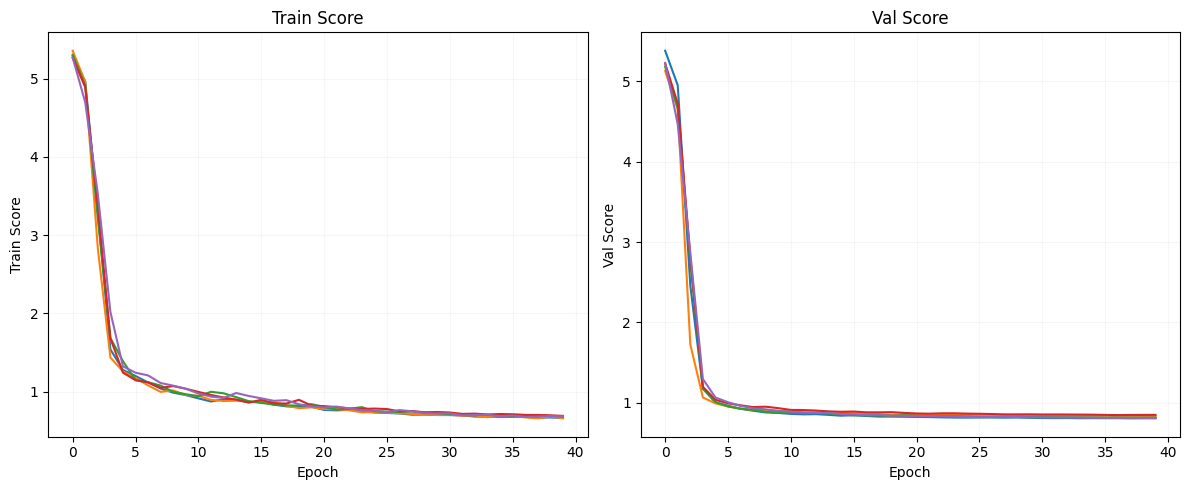

In [21]:
main()

# inference

In [22]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_167072/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_cnn_swin_small/atmacup_18-models/swin_small_patch4_window7_224_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small/atmacup_18-models/swin_small_patch4_window7_224_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small/atmacup_18-models/swin_small_patch4_window7_224_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small/atmacup_18-models/swin_small_patch4_window7_224_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]